Fetch the NYC portal metadata. To do this we use the `pysocrata` package, installable via `pip`.

In [2]:
import json

with open("../auth/nyc-open-data.json", "r") as f:
    nyc_auth = json.load(f)

In [6]:
import pysocrata
nyc_datasets = pysocrata.get_datasets(**nyc_auth)

Example metadata component:

In [14]:
print(json.dumps(nyc_datasets[0], indent=4))

{
    "link": "https://data.cityofnewyork.us/Transportation/Medallion-Drivers-Active/jb3k-j3gp",
    "resource": {
        "download_count": 92693,
        "columns_description": [
            "",
            "",
            "",
            "",
            "",
            ""
        ],
        "updatedAt": "2017-01-21T19:46:23.000Z",
        "parent_fxf": null,
        "provenance": "official",
        "name": "Medallion Drivers - Active",
        "attribution": "Taxi and Limousine Commission (TLC)",
        "createdAt": "2013-12-26T19:23:30.000Z",
        "columns_field_name": [
            "license_number",
            "name",
            "type",
            "expiration_date",
            "last_updated_date",
            "last_updated_time"
        ],
        "description": "This list contains the most recently published active  medallion drivers list. This is a list of licensees who are currently authorized to operate NYC TLC licensed Taxicabs. The old data set is no longer being up

In [19]:
nyc_endpoints = [d['resource']['id'] for d in nyc_datasets]

In [21]:
nyc_endpoints[:5]

['jb3k-j3gp', 'jgtb-hmpg', 'vwpc-kje2', '8vv7-7wx3', 'tvpp-9vvx']

In [22]:
nyc_types = [d['resource']['type'] for d in nyc_datasets]

In [24]:
import pandas as pd
pd.Series(nyc_types).value_counts()

dataset    1132
href        182
map         166
file         99
story         3
dtype: int64

Stories crept into here because they're a new "thing" that Socrata is promoting. Interesting that they consider them to be datasets. For further information on how these counts are generated (TLDR it's non-trivial) see [here](http://nbviewer.jupyter.org/github/ResidentMario/socrata-portal-metadata/blob/master/notebooks/Socrata%20Portal%20Dataset%20Counting%20Scoping.ipynb). 

We have to remember to remove these "datasets" from consideration during processing.

In [46]:
nyc_datasets = [d for d in nyc_datasets if d['resource']['type'] != 'story']

Additionally, the names attached to the resources here are the names attached to them in the underlying Socrata server. We will rename them to match our own volcabulary.

In [52]:
nyc_types = [d['resource']['type'] for d in nyc_datasets]

In [53]:
volcab_map = {'dataset': 'table', 'href': 'link', 'map': 'geospatial dataset', 'file': 'blob'}
nyc_types = list(map(lambda d: volcab_map[d], nyc_types))

In [56]:
pd.Series(nyc_types).value_counts()

table                 1132
link                   182
geospatial dataset     166
blob                    99
dtype: int64

Ok, now we need to do manual ground truthing. What datasets contain timeseries data? What datasets contain geospatial data? The idea is that we need to be able to assess this semi-autonomously.

In [59]:
import numpy as np
table_endpoints = np.array(nyc_endpoints)[np.nonzero([t == 'table' for t in nyc_types])]

Copy paste the following output into Excel:

In [64]:
# [print(e) for e in table_endpoints]
# pass

In [70]:
i = 0

In [82]:
print("https://data.cityofnewyork.us/-/-/" + table_endpoints[i])
i += 1

https://data.cityofnewyork.us/-/-/szkz-syh6


In [85]:
from IPython.display import Image

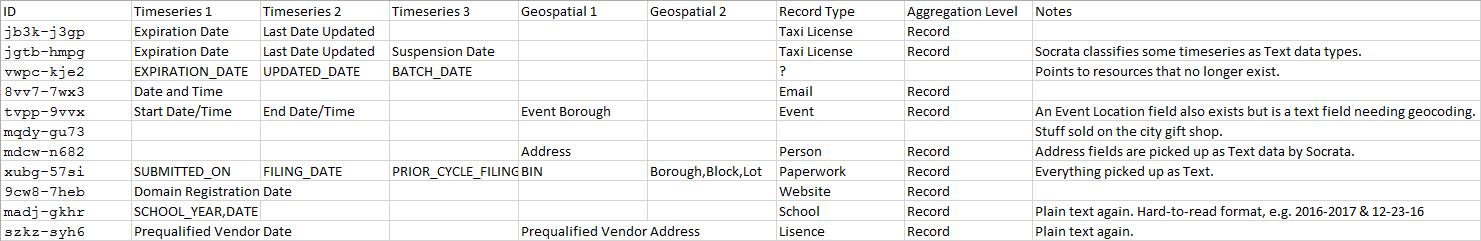

In [86]:
Image("../figures/table-data-leafing.png")

Ok, I tried this out on a dozen datasets. What is clear is that:

* Socrata has some data on when a column is or isn't a Date/Time. However, that data is not available via metadata (it has to be taken off of their site).
* That information is regardless very inaccurate. Many columns that are really in a date/time format (or a location format) are simply marked as "TEXT" types.
* Sometimes geospatial information or date/time information can be read out of combinations of columns, but not out of any single one.
* Addresses are pretty common, these would need to be geocoded to point to anywhere geospatially usable however.

It seems that to take advantage of this data we'd need to figure out a robust way of mixing and matching data column formats of some kind. So that's a challenge.

Fair enough, but this is a challenge of analysis. Before we get to that, we first have to systemitize access.